# Imports

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import math
import cv2

from ultralytics import YOLO

In [3]:
class_names = ['arrow', 'arrow_head']
model = YOLO("yolo_arrow.pt")

In [4]:
def segment(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    markers = cv2.connectedComponents(thresh)[1]
    
    total_pixels = image.size
    
    segmented_regions = []
    regional_coords = []
    
    for label in np.unique(markers):
        if label == -1:
            continue  # Skip the background
    
        mask = np.zeros_like(gray, dtype=np.uint8)
        mask[markers == label] = 255
    
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
        non_black_pixels = cv2.countNonZero(mask)
        percentage_non_black = (non_black_pixels / total_pixels) * 100
    
        # Check if the region has more than 0.3% non-black pixels
        if percentage_non_black > 0.3:
            
            # save coordinates
            (x, y, width, height) = cv2.boundingRect(contours[0])
            if width > 5 and height > 5:
                
                added = False
                for other_region in segmented_regions:
                    if other_region[0][0] == x:
                        for subregion in other_region:
                            if subregion[1] + subregion[3] in range(y - 10, y + 10):
                                other_region.append((x, y, width, height))
                                added = True
                                break
                if not added:
                    segmented_regions.append([(x, y, width, height)])
        
    segmented_regions.pop(0) # remove the whole diagram
    
    for region in segmented_regions:
        region_coords = [
            (region[0][0], region[0][1]), 
            (region[0][0] + region[0][2], region[-1][1] + region[-1][3])
        ]
        regional_coords.append(region_coords)
    
    return segmented_regions, regional_coords

In [5]:
img_path = 'diagrams/employee_inher.jpg'
# img_path = 'diagrams/cuisine_subclasses.jpg'

In [6]:
image = cv2.imread(img_path)

In [7]:
from operator import itemgetter

def get_coordinates(model, image, classes):
    arrows, heads = [], []
    result = model.predict(image)[0]
    
    for box in result.boxes:
        x1, y1, x2, y2 = box.xyxy[0]
        x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
        conf = math.ceil((box.conf[0]*100))/100
        label = classes[int(box.cls[0])]
        
        if label == 'arrow':
            arrows.append([(x1, y1), (x2, y2)])
        else:
            heads.append([(x1, y1), (x2, y2)])
    
    return sorted(arrows, key=itemgetter(0)), sorted(heads, key=itemgetter(0))

In [8]:
coords = get_coordinates(model, image, class_names)
coords

Ultralytics YOLOv8.0.20  Python-3.10.4 torch-2.1.2+cu118 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
Model summary (fused): 218 layers, 25840918 parameters, 0 gradients, 78.7 GFLOPs


([[(462, 1028), (1740, 1397)], [(465, 805), (1022, 987)]],
 [[(466, 1038), (541, 1101)], [(470, 901), (542, 972)]])

In [9]:
segment_result = segment(image)
segment_result

([[(1028, 31, 2731, 175), (1028, 213, 2731, 362), (1028, 581, 2731, 363)],
  [(28, 897, 431, 219)],
  [(1731, 1069, 1325, 175), (1731, 1250, 1325, 362), (1731, 1619, 1325, 362)]],
 [[(1028, 31), (3759, 944)],
  [(28, 897), (459, 1116)],
  [(1731, 1069), (3056, 1981)]])

In [10]:
segment_result[1]

[[(1028, 31), (3759, 944)],
 [(28, 897), (459, 1116)],
 [(1731, 1069), (3056, 1981)]]

In [11]:
arrow_boxes = {}

for arrow in coords[0]: # coords[0]
    arrow_boxes[str(arrow)] = set()

    for box in segment_result[1]:
        arrow_coord = [0, 1]
        box_coord = [0, 1]
        x_or_y_list = [0, 1]
        
        for box_c in box_coord:
            for arr_c in arrow_coord:
                for x_or_y in x_or_y_list:
                    
                    if arrow[arr_c][x_or_y] in range(box[box_c][x_or_y] - 10, box[box_c][x_or_y] + 10):
                        if (
                            arrow[arr_c][int(not x_or_y)] in range(box[0][int(not x_or_y)] - 10, box[1][int(not x_or_y)] + 10)
                        or
                            arrow[int(not arr_c)][int(not x_or_y)] in range(box[0][int(not x_or_y)] - 10, box[1][int(not x_or_y)] + 10)
                        ):
                            arrow_boxes[str(arrow)].add(str(box))

arrow_boxes


{'[(462, 1028), (1740, 1397)]': {'[(1731, 1069), (3056, 1981)]',
  '[(28, 897), (459, 1116)]'},
 '[(465, 805), (1022, 987)]': {'[(1028, 31), (3759, 944)]',
  '[(28, 897), (459, 1116)]'}}

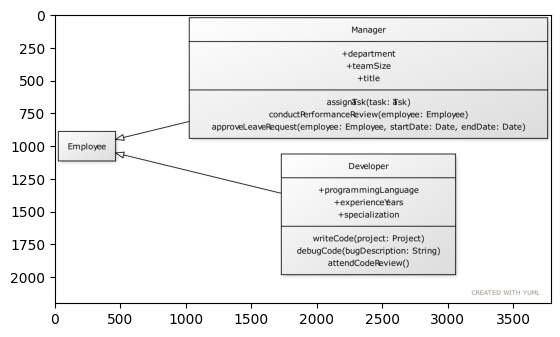

In [12]:
plt.imshow(image)
plt.show()